In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
TRAIN_PATH= '/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Train'
VAL_PATH= '/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Validation'


Libraries

In [ ]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import * 
from keras.models import * 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras import optimizers
from keras.preprocessing import image 
from sklearn.metrics import precision_score,recall_score,classification_report
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
from tensorflow.keras.callbacks import EarlyStopping

Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_dataset = image.ImageDataGenerator(rescale=1./255)

early_stopping = EarlyStopping(
    monitor='val_acc', 
    patience=5, 
    min_delta=0.001, 
    mode='max'
)
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/FaceMask/Model Simple/model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')


Model Building


In [ ]:
INIT_LR = 1e-4
BS = 8
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
opt = optimizers.Adam(learning_rate=INIT_LR)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

Model Training

In [ ]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = BS,
    class_mode = 'binary')
validation_generator = test_dataset.flow_from_directory(
    VAL_PATH,
    target_size = (224,224),
    batch_size = BS,
    class_mode = 'binary')
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator)//BS,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps=len(validation_generator)//BS
    ,callbacks=[checkpoint,early_stopping])


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
156/156 [==============================] - 54s 331ms/step - loss: 0.6327 - acc: 0.6747 - val_loss: 0.4814 - val_acc: 0.8750
Epoch 2/100
156/156 [==============================] - 44s 285ms/step - loss: 0.3705 - acc: 0.8646 - val_loss: 0.4139 - val_acc: 0.9167
Epoch 3/100
156/156 [==============================] - 41s 261ms/step - loss: 0.3106 - acc: 0.8830 - val_loss: 0.3613 - val_acc: 0.8646
Epoch 4/100
156/156 [==============================] - 40s 257ms/step - loss: 0.3004 - acc: 0.8966 - val_loss: 0.2776 - val_acc: 0.9375
Epoch 5/100
156/156 [==============================] - 34s 221ms/step - loss: 0.2809 - acc: 0.8910 - val_loss: 0.2883 - val_acc: 0.9062
Epoch 6/100
156/156 [==============================] - 34s 215ms/step - loss: 0.2952 - acc: 0.8830 - val_loss: 0.3429 - val_acc: 0.8542
Epoch 7/100
156/156 [==============================] - 33s 213ms/step - loss: 0.2792 - acc: 0.8926 - val_loss: 0.2603 - val_acc: 0.9271
Epoch 8/100
156/156 [===========================

Save Model


In [ ]:
model.save("/content/gdrive/MyDrive/FaceMask/FM_Simple_CNN.h5")

Plotting Training Accuracy





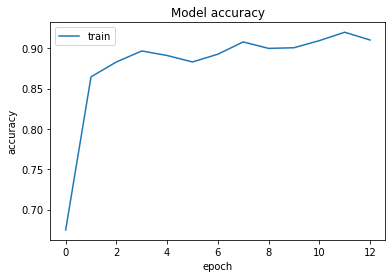

In [ ]:
plt.plot(hist.history['acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

Plotting Validation Accuracy


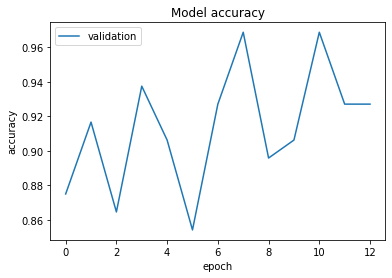

In [ ]:
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation'],loc='upper left')
plt.show()

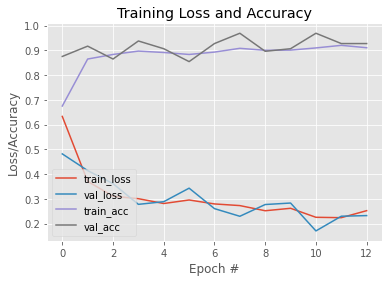

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot(hist.history["acc"], label="train_acc")
plt.plot(hist.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


Getting Results

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       509
           1       0.99      0.82      0.89       483

    accuracy                           0.91       992
   macro avg       0.92      0.90      0.90       992
weighted avg       0.92      0.91      0.90       992



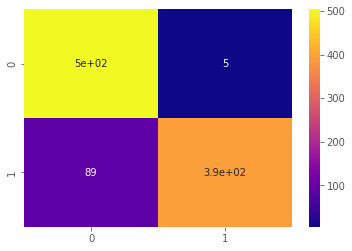

In [ ]:
import os 
y_actual=[]
y_test=[]
for i in os.listdir("/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Test/WithoutMask"):
  img=image.load_img("/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Test/WithoutMask/"+i,target_size=(224,224))
  img=image.img_to_array(img)
  img=np.expand_dims(img,axis=0)
  p=(model.predict(img) > 0.5).astype("int32")
  y_test.append(p[0,0])
  y_actual.append(0)

for i in os.listdir("/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Test/WithMask"):
  img=image.load_img("/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Test/WithMask/"+i,target_size=(224,224))
  img=image.img_to_array(img)
  img=np.expand_dims(img,axis=0)
  p=(model.predict(img)>0.5).astype("int32")
  y_test.append(p[0,0])
  y_actual.append(1)

y_actual=np.array(y_actual)
y_test=np.array(y_test)

from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score
import seaborn as sns

#plotting confusion metrics
cm=confusion_matrix(y_actual,y_test)
from sklearn.metrics import classification_report
sns.heatmap(cm,cmap="plasma",annot=True)

#getting numerical metrics 
print(classification_report(y_actual,y_test))

ROC Curve

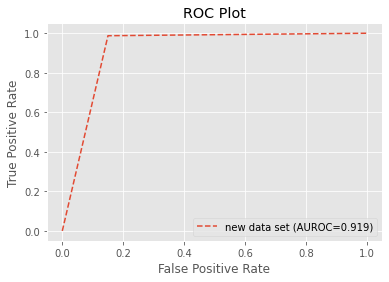

In [ ]:
#plotting ROC curve 
r_auc_new_dataset=roc_auc_score(y_test,y_actual)
r_fpr_new_dataset,r_tpr_new_dataset,_=roc_curve(y_test,y_actual)
plt.plot(r_fpr_new_dataset,r_tpr_new_dataset,linestyle='--',label='new data set (AUROC=%0.3f)' %r_auc_new_dataset)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Testing

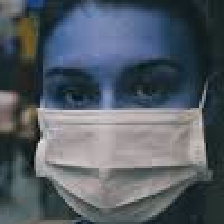

WithMask


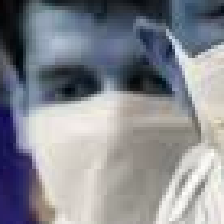

WithMask


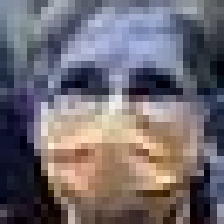

WithMask


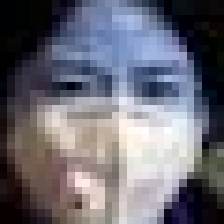

WithMask


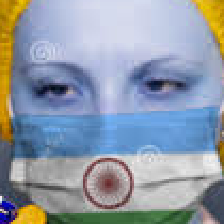

WithMask


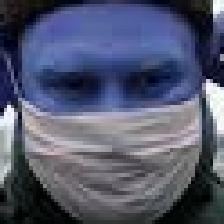

WithMask


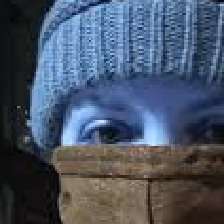

WithMask


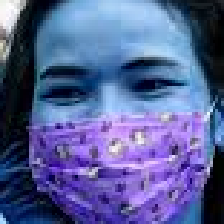

WithoutMask


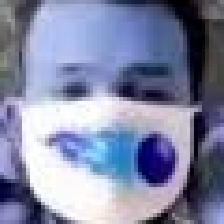

WithMask


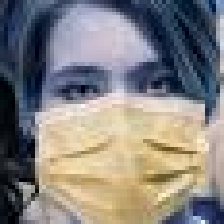

WithMask


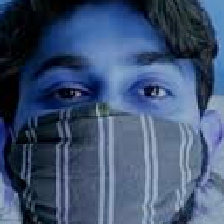

WithoutMask


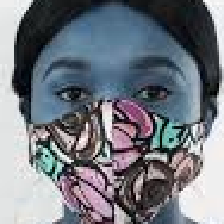

WithMask


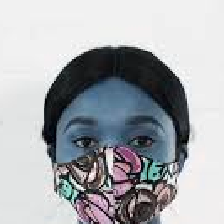

WithMask


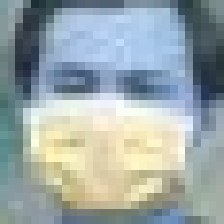

WithMask


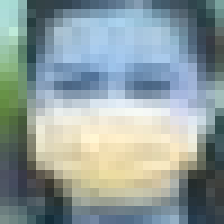

WithMask


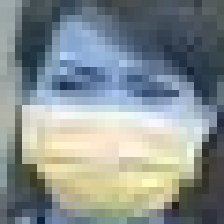

WithMask


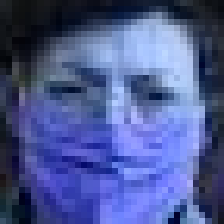

WithoutMask


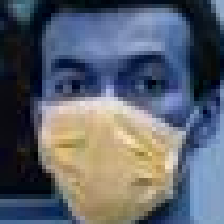

WithMask


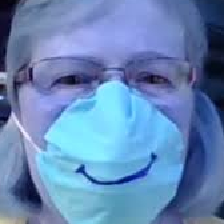

WithoutMask


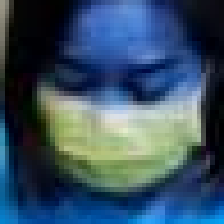

WithMask


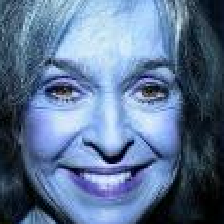

WithoutMask


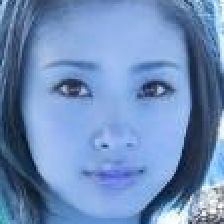

WithoutMask


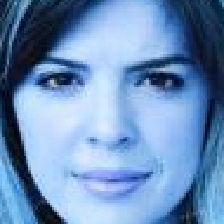

WithoutMask


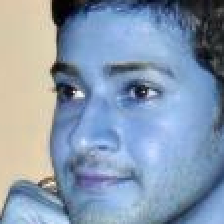

WithoutMask


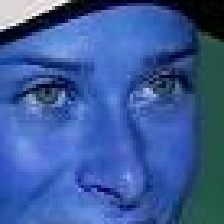

WithoutMask


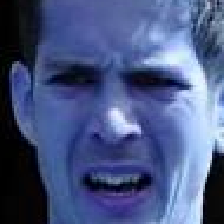

WithoutMask


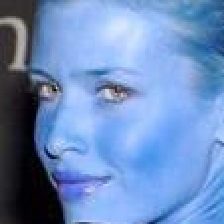

WithoutMask


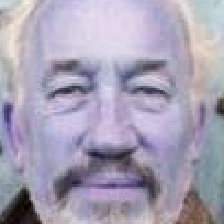

WithoutMask


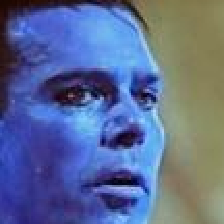

WithoutMask


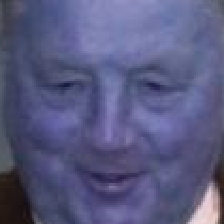

WithoutMask


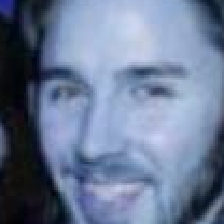

WithoutMask


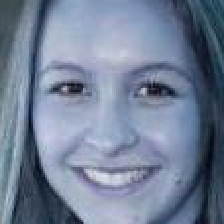

WithoutMask


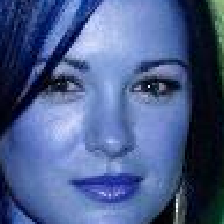

WithoutMask


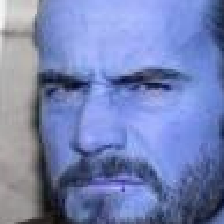

WithoutMask


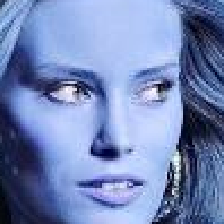

WithoutMask


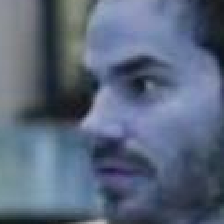

WithoutMask


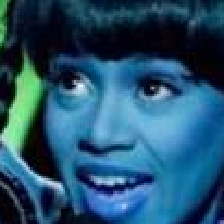

WithoutMask


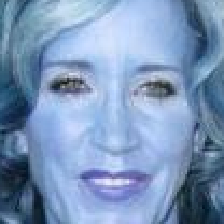

WithoutMask


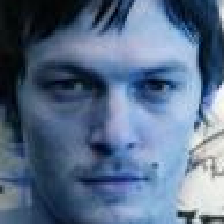

WithoutMask


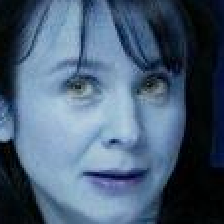

WithoutMask


In [ ]:
CATEGORIES=["WithoutMask","WithMask"]
from google.colab.patches import cv2_imshow

for i in os.listdir("/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Test/Random"):
  img=image.load_img("/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Test/Random/"+i,target_size=(224,224))
  img=image.img_to_array(img)
  cv2_imshow(img)
  img=np.expand_dims(img,axis=0)
  prediction=model.predict(img)

  print(CATEGORIES[int (prediction[0][0])])



In [ ]:
while True:pass